/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns o

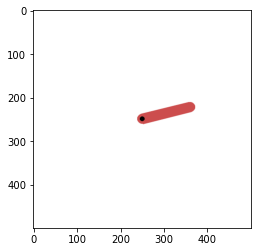

In [1]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('Pendulum-v1')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [2]:
import torch


#定义模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_statu = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
        )

        self.fc_mu = torch.nn.Sequential(
            torch.nn.Linear(128, 1),
            torch.nn.Tanh(),
        )

        self.fc_std = torch.nn.Sequential(
            torch.nn.Linear(128, 1),
            torch.nn.Softplus(),
        )

    def forward(self, state):
        state = self.fc_statu(state)

        mu = self.fc_mu(state) * 2.0
        std = self.fc_std(state)

        return mu, std


model = Model()

model_td = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
)

model(torch.randn(2, 3)), model_td(torch.randn(2, 3))

((tensor([[-0.4218],
          [-0.6039]], grad_fn=<MulBackward0>),
  tensor([[0.8276],
          [0.6361]], grad_fn=<SoftplusBackward0>)),
 tensor([[-0.1162],
         [ 0.3451]], grad_fn=<AddmmBackward0>))

In [3]:
import random


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 3)
    mu, std = model(state)

    #根据概率选择一个动作
    #action = random.normalvariate(mu=mu.item(), sigma=std.item())
    action = torch.distributions.Normal(mu, std).sample().item()

    return action


get_action([1, 2, 3])

1.6533619165420532

In [4]:
def get_data():
    states = []
    rewards = []
    actions = []
    next_states = []
    overs = []

    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step([action])

        #记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        next_states.append(next_state)
        overs.append(over)

        #更新游戏状态,开始下一个动作
        state = next_state

    #[b, 3]
    states = torch.FloatTensor(states).reshape(-1, 3)
    #[b, 1]
    rewards = torch.FloatTensor(rewards).reshape(-1, 1)
    #[b, 1]
    actions = torch.FloatTensor(actions).reshape(-1, 1)
    #[b, 3]
    next_states = torch.FloatTensor(next_states).reshape(-1, 3)
    #[b, 1]
    overs = torch.LongTensor(overs).reshape(-1, 1)

    return states, rewards, actions, next_states, overs


get_data()

/root/anaconda3/envs/cpu/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)


(tensor([[-9.4053e-01, -3.3972e-01,  3.7363e-01],
         [-9.3583e-01, -3.5246e-01,  2.7161e-01],
         [-9.3706e-01, -3.4917e-01, -7.0195e-02],
         [-9.4259e-01, -3.3396e-01, -3.2371e-01],
         [-9.4930e-01, -3.1438e-01, -4.1397e-01],
         [-9.6195e-01, -2.7324e-01, -8.6081e-01],
         [-9.7622e-01, -2.1678e-01, -1.1648e+00],
         [-9.9040e-01, -1.3821e-01, -1.5973e+00],
         [-9.9875e-01, -5.0036e-02, -1.7720e+00],
         [-9.9866e-01,  5.1781e-02, -2.0372e+00],
         [-9.8847e-01,  1.5145e-01, -2.0046e+00],
         [-9.6766e-01,  2.5227e-01, -2.0599e+00],
         [-9.3783e-01,  3.4709e-01, -1.9887e+00],
         [-8.9914e-01,  4.3766e-01, -1.9706e+00],
         [-8.5247e-01,  5.2278e-01, -1.9423e+00],
         [-8.0890e-01,  5.8795e-01, -1.5682e+00],
         [-7.7299e-01,  6.3441e-01, -1.1746e+00],
         [-7.4570e-01,  6.6628e-01, -8.3914e-01],
         [-7.2646e-01,  6.8721e-01, -5.6870e-01],
         [-7.2265e-01,  6.9122e-01, -1.1059e-01],


In [5]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1415.7139636834195

In [6]:
#优势函数
def get_advantages(deltas):
    advantages = []

    #反向遍历deltas
    s = 0.0
    for delta in deltas[::-1]:
        s = 0.9 * 0.9 * s + delta
        advantages.append(s)

    #逆序
    advantages.reverse()
    return advantages


get_advantages(range(5))

[5.43839184, 6.7140640000000005, 7.0544, 6.24, 4.0]

In [7]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    optimizer_td = torch.optim.Adam(model_td.parameters(), lr=5e-3)
    loss_fn = torch.nn.MSELoss()

    #玩N局游戏,每局游戏训练M次
    for epoch in range(3000):
        #玩一局游戏,得到数据
        #states -> [b, 3]
        #rewards -> [b, 1]
        #actions -> [b, 1]
        #next_states -> [b, 3]
        #overs -> [b, 1]
        states, rewards, actions, next_states, overs = get_data()

        #偏移reward,便于训练
        rewards = (rewards + 8) / 8

        #计算values和targets
        #[b, 3] -> [b, 1]
        values = model_td(states)

        #[b, 3] -> [b, 1]
        targets = model_td(next_states).detach()
        targets = targets * 0.98
        targets *= (1 - overs)
        targets += rewards

        #计算优势,这里的advantages有点像是策略梯度里的reward_sum
        #只是这里计算的不是reward,而是target和value的差
        #[b, 1]
        deltas = (targets - values).squeeze(dim=1).tolist()
        advantages = get_advantages(deltas)
        advantages = torch.FloatTensor(advantages).reshape(-1, 1)

        #取出每一步动作的概率
        #[b, 3] -> [b, 1],[b, 1]
        mu, std = model(states)
        #[b, 1]
        old_probs = torch.distributions.Normal(mu, std)
        old_probs = old_probs.log_prob(actions).exp().detach()

        #每批数据反复训练10次
        for _ in range(10):
            #重新计算每一步动作的概率
            #[b, 3] -> [b, 1],[b, 1]
            mu, std = model(states)
            #[b, 1]
            new_probs = torch.distributions.Normal(mu, std)
            new_probs = new_probs.log_prob(actions).exp()

            #求出概率的变化
            #[b, 1] - [b, 1] -> [b, 1]
            ratios = new_probs / old_probs

            #计算截断的和不截断的两份loss,取其中小的
            #[b, 1] * [b, 1] -> [b, 1]
            surr1 = ratios * advantages
            #[b, 1] * [b, 1] -> [b, 1]
            surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages

            loss = -torch.min(surr1, surr2)
            loss = loss.mean()

            #重新计算value,并计算时序差分loss
            values = model_td(states)
            loss_td = loss_fn(values, targets)

            #更新参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            optimizer_td.zero_grad()
            loss_td.backward()
            optimizer_td.step()

        if epoch % 200 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, test_result)


train()

0 -1446.5204075078423
200 -932.1814435433156
400 -1030.0278075516812
600 -751.2112530028242
800 -504.56214891559057
1000 -560.9322619365445
1200 -738.7339707655535
1400 -719.4224152979951
1600 -291.7831274603024
1800 -309.8623235047338
2000 -431.92403133840037
2200 -214.6124410963978
2400 -339.9867063157487
2600 -272.16941303297926
2800 -479.08053363642273


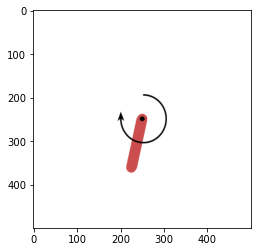

-447.0247764319355

In [8]:
test(play=True)